In [1]:
# Load libraries
import torch 
import pandas as pd 
import numpy as np
import json
import tokenizers
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
import pickle

from torch import tensor
from torch.utils.data import DataLoader, Dataset
from transformers import  RobertaConfig
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.models import WordLevel, BPE
from tokenizers import pre_tokenizers, normalizers, Tokenizer
from tokenizers.normalizers import Lowercase, NFD
from tokenizers.pre_tokenizers import ByteLevel, Whitespace
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from utils.utils import prob2label
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from tqdm import tqdm


In [7]:
# Load settings
with open("settings.json","r") as inFile:
    settings = json.load(inFile)
    
# Load train and test dataset and merge
train_dataset = pd.read_csv(settings['file']['train_data'])
test_dataset = pd.read_csv(settings['file']['test_data'])
dataset = pd.concat([train_dataset, test_dataset], axis=0)
dataset

,CDR3a,CDR3b,activated_by,num_label,activatedby_HA,activatedby_HCRT,activatedby_NP,negative,activated_any
0,CILQTQGGSEKLVF,CASSIGTSVAGYTF,NP136,5,0,0,1,0,1
1,CVVSDLPPGGKLIF,CASSTSTGGGQPQHF,HA69,0,1,0,0,0,1
2,CAVKTGGFKTIF,CSAIQGAASYEQYF,NP136,5,0,0,1,0,1
3,CAGDTASKLTF,CASSGTSGTYNEQFF,NP136,5,0,0,1,0,1
4,CAVDRYGNKLVF,CASSRASGFSTDTQYF,HCRT,3,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
1859,CAVSRGGSNYKLTF,CASSLAGLAVETQYF,negative,6,0,0,0,1,0
1860,CAVRGAQGAQKLVF,CASSPGGTANYEQYF,negative,6,0,0,0,1,0
1861,CAVISNFGNEKLTF,CASSQITGASNEQFF,negative,6,0,0,0,1,0
1862,CAASIQGGSEKLVF,CASSWGLAQETQYF,NP136,5,0,0,1,0,1


In [3]:
# Init
AA_alpha, AA_beta = defaultdict(list), defaultdict(list)
AA_df_alpha, AA_df_beta = pd.DataFrame(columns=["AA","position","activated_by"]), pd.DataFrame(columns=["AA","position","activated_by"])

# Iterate over all chains to find AA position distribution
for row in tqdm(dataset.iterrows()):
    
    for idx, AA in enumerate(row[1].CDR3a):
        AA_alpha[AA] += [idx/len(row[1].CDR3a)]    
        AA_df_alpha = AA_df_alpha.append({"AA":AA, "position":idx/len(row[1].CDR3b), "activated_by":row[1].activated_by}, ignore_index=True)    
    for idx, AA in enumerate(row[1].CDR3b):
        AA_beta[AA] += [idx/len(row[1].CDR3b)]
        AA_df_beta = AA_df_beta.append({"AA":AA, "position":idx/len(row[1].CDR3b), "activated_by":row[1].activated_by}, ignore_index=True)    

6181it [09:30, 10.84it/s]


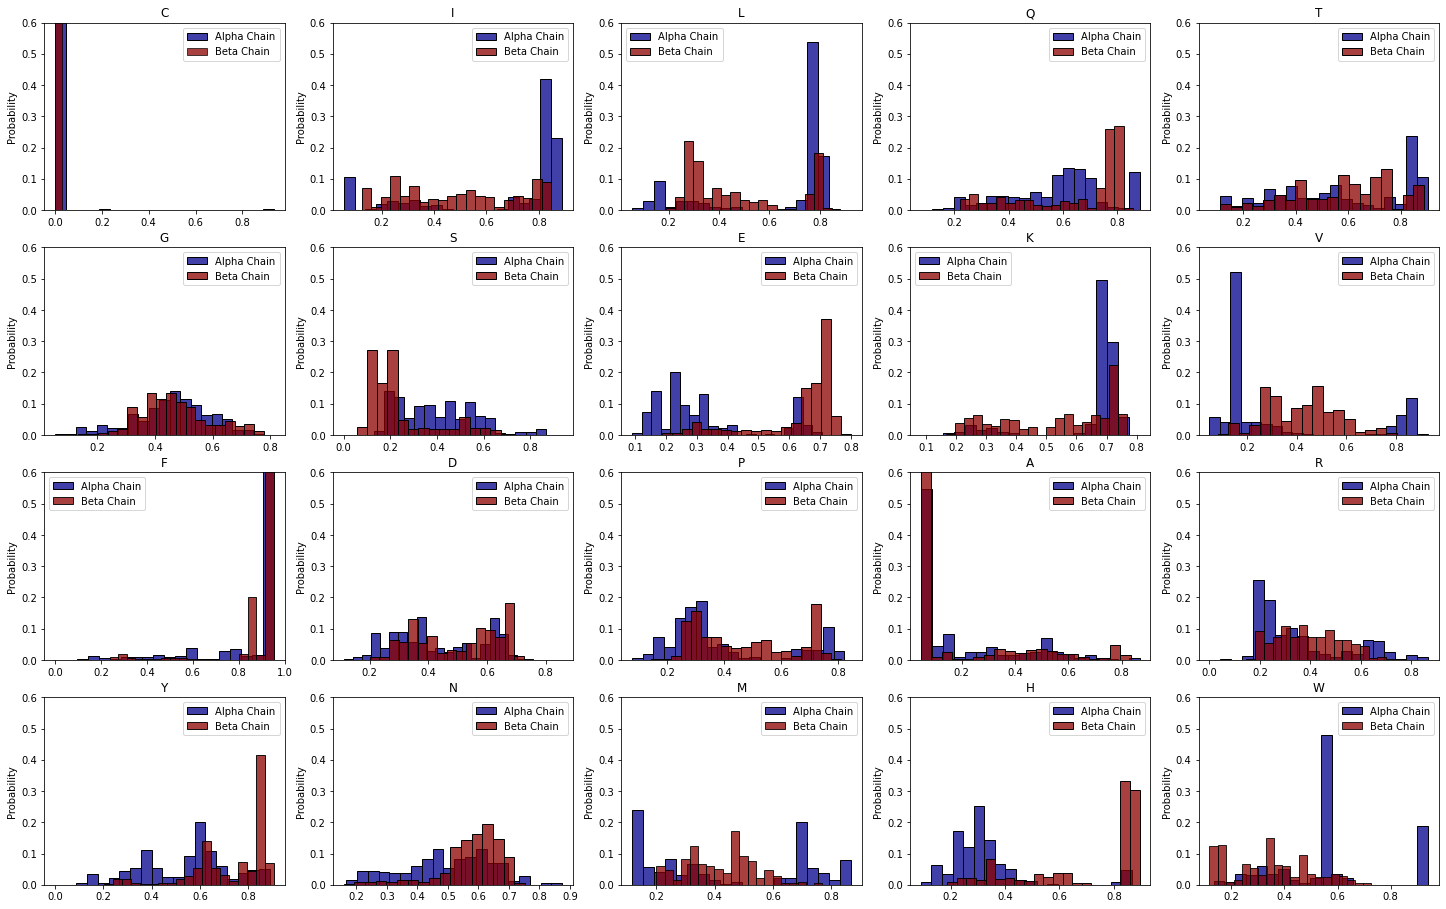

In [34]:
%matplotlib inline
fig = plt.figure(1, figsize=(25,20))
for idx, AA in enumerate(AA_alpha.keys()):
    plt.subplot(5,5,idx+1)
    sns.histplot(AA_alpha[AA], kde=False, color = 'darkblue', stat="probability", bins=20)
    plt.ylim(0, 0.6)
    sns.histplot(AA_beta[AA], kde=False, color = 'darkred', stat="probability", bins=20)
    plt.ylim(0, 0.6)
    plt.legend(labels=["Alpha Chain","Beta Chain"])
    plt.title(AA)
plt.show()
fig.savefig('AA_alpha_beta_dist.png', facecolor='w', transparent=False)

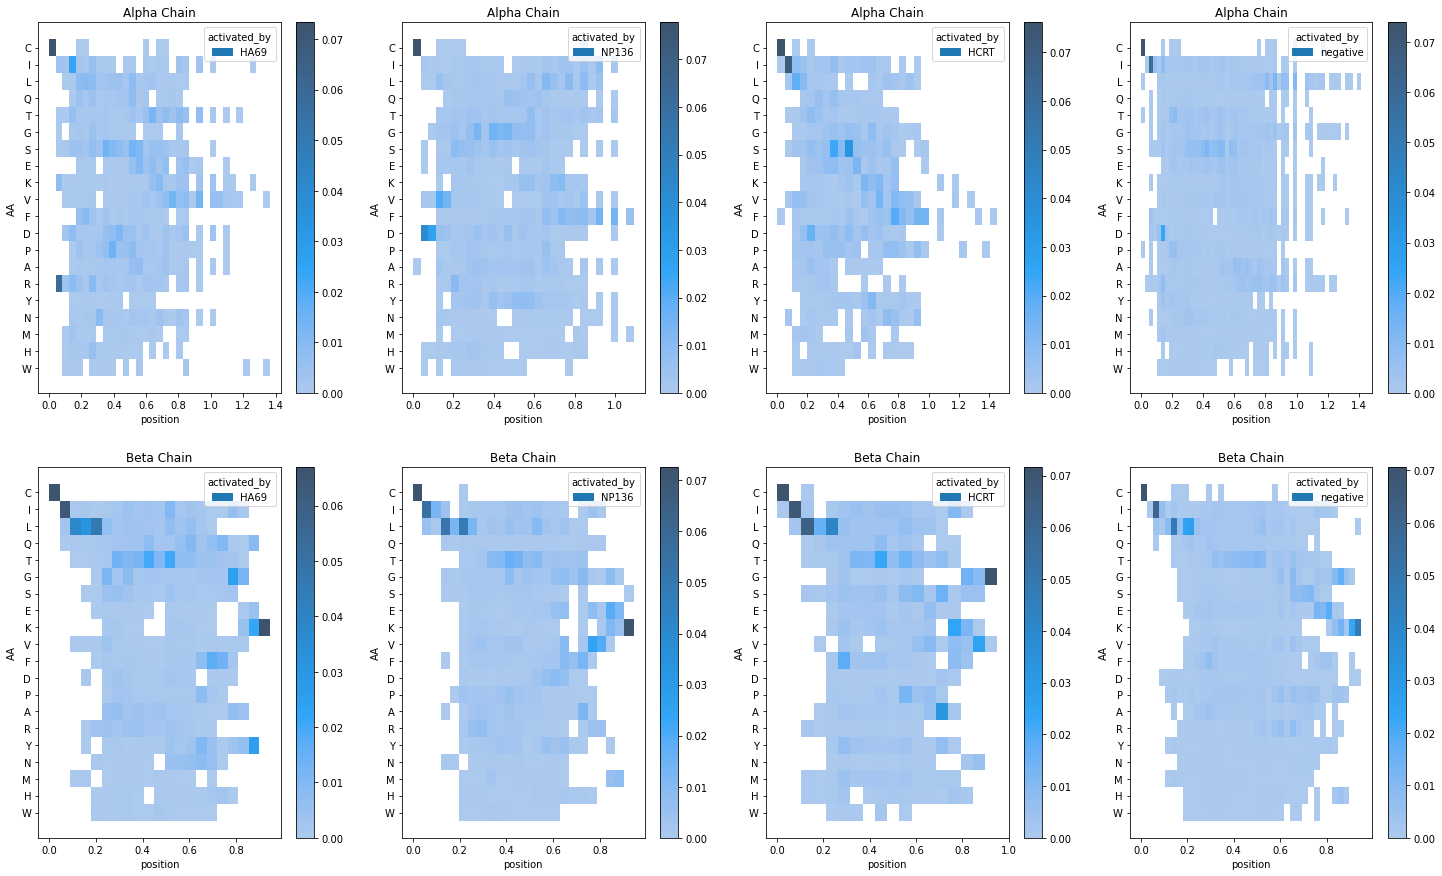

In [35]:
%matplotlib inline
fig = plt.figure(1, figsize=(25,15))
for idx, peptide in enumerate(["HA69", "NP136", "HCRT", "negative"]):
    plt.subplot(2,4,idx+1)
    g = sns.histplot(AA_df_alpha[AA_df_alpha.activated_by == peptide],
                    x="position", y = "AA", hue="activated_by", stat="probability", discrete=(False, True), cbar=True)
    g.set_yticks(range(len(list(AA_alpha.keys()))))
    g.set_yticklabels(list(AA_alpha.keys()))
    plt.title("Alpha Chain")
for idx, peptide in enumerate(["HA69", "NP136", "HCRT", "negative"]):
    plt.subplot(2,4,idx+5)
    g = sns.histplot(AA_df_beta[AA_df_beta.activated_by == peptide],
                    x="position", y = "AA", hue="activated_by", stat="probability", discrete=(False, True), cbar=True)
    g.set_yticks(range(len(list(AA_alpha.keys()))))
    g.set_yticklabels(list(AA_alpha.keys()))
    plt.title("Beta Chain")
fig.savefig('alpha_beta_AA_post_by_pep.png', facecolor='w', transparent=False)


# 2. Amino acid influence in output probability 


In [9]:
# Create dataset
class CDR3Dataset(Dataset):
    
    def __init__(self, settings:dict, train:bool = True, label:str = None, tokenizer:tokenizers.Tokenizer=None, equal:bool=False) -> None:
        cols = ["activatedby_HA", "activatedby_NP", "activatedby_HCRT", "activated_any", "multilabel", "negative"]
        if label not in cols:
            raise ValueError("Invalid label type. Expected one of %s" % cols)
        else: 
            self.label = label
        if equal and label == "num_label":
            raise ValueError("Equal size sets only allowed for binary classifications. num_label is multiclass.")
        
        if train == True:
            path_to_data = settings["file"]["train_data"] 
        else:
            path_to_data = settings["file"]["test_data"]   
              
        self.path_to_data = path_to_data
        self.data = pd.read_csv(self.path_to_data)
        if equal == True:
            min_sample=np.min(self.data[self.label].value_counts()) 
            data_pos = self.data[self.data[self.label]==1].sample(min_sample)
            data_neg = self.data[self.data[self.label]==0].sample(min_sample)
            self.data = pd.concat([data_pos, data_neg], ignore_index=True)
        
        if label == "multilabel":
            self.labels = [0,1]
            self.n_labels = 3
        else:
            self.labels = np.unique(self.data[[self.label]])
            self.n_labels = len(self.labels)
            
        self.max_len_CDRa = self.data.CDR3a.str.len().max()
        self.max_len_CDRb = self.data.CDR3b.str.len().max()
        self.max_len = max(self.max_len_CDRa, self.max_len_CDRb)
        
        self.tokenizer = tokenizer
        
    def __getitem__(self, index:int):
        if isinstance(self.tokenizer.model, tokenizers.models.WordLevel):
            item = {
                "CDR3a": self.data.CDR3a[index],
                "CDR3b": self.data.CDR3b[index]
                }
        elif isinstance(self.tokenizer.model, tokenizers.models.BPE):
            self.tokenizer.enable_padding(length=self.max_len)
            encodings_CDR3a = self.tokenizer.encode(self.data.CDR3a[index]) 
            encodings_CDR3b = self.tokenizer.encode(self.data.CDR3b[index]) 
            item = {
                "ids_CDR3a":tensor(encodings_CDR3a.ids, dtype=torch.long),
                "ids_CDR3b":tensor(encodings_CDR3b.ids, dtype=torch.long),
                "attention_mask_CDR3a": tensor(encodings_CDR3a.attention_mask, dtype=torch.long),
                "attention_mask_CDR3b": tensor(encodings_CDR3b.attention_mask, dtype=torch.long),
                "CDR3a": self.data.CDR3a[index],
                "CDR3b": self.data.CDR3b[index]
                }
        if self.label == "multilabel":
            item["target"] = tensor(self.data[["activatedby_HA", "activatedby_NP", "activatedby_HCRT"]].iloc[index], dtype=torch.long)
            item["label"] = self.data["activated_by"].iloc[index]
        else:
            item["target"] = [self.data[self.label][index]]
            item["label"] = self.data["activated_by"].iloc[index]
        return item

    def __len__(self):
        return len(self.data)

In [8]:
# Set device 
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load model
model = torch.load('best_model_test')
model.to(device)
model.eval()

Net(
  (roberta_embeddings_alpha): RobertaEmbeddings(
    (word_embeddings): Embedding(25, 1032, padding_idx=1)
    (position_embeddings): Embedding(512, 1032, padding_idx=1)
    (token_type_embeddings): Embedding(2, 1032)
    (LayerNorm): LayerNorm((1032,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (roberta_embeddings_beta): RobertaEmbeddings(
    (word_embeddings): Embedding(25, 1032, padding_idx=1)
    (position_embeddings): Embedding(512, 1032, padding_idx=1)
    (token_type_embeddings): Embedding(2, 1032)
    (LayerNorm): LayerNorm((1032,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (roberta_encoding): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=1032, out_features=1032, bias=True)
            (key): Linear(in_features=1032, out_features=1032, bias=True)
 

In [10]:
# Create tonekizer from tokenizers library 
if settings["param"]["tokenizer"] == "BPE":
    tokenizer = Tokenizer(BPE()).from_file(settings["tokenizer"]["BPE"])
elif settings["param"]["tokenizer"] == "WL":
    tokenizer = Tokenizer(WordLevel()).from_file(settings["tokenizer"]["WL"])
else:
    raise ValueError("Unknown tokenizer. Tokenizer argument must be BPE or WL.")
tokenizer.enable_padding()
    
# Create training and test dataset
dataset_params={"label":settings["database"]["label"], "tokenizer":tokenizer}
train_data = CDR3Dataset(settings,train=True, equal=False, **dataset_params)
test_data =CDR3Dataset(settings, train=False, **dataset_params)

# Crate dataloaders
loader_params = {'batch_size': 1,
            'shuffle': False,
            'num_workers': 0
            }
train_dataloader = DataLoader(train_data, **loader_params)
test_dataloader = DataLoader(test_data, **loader_params)

# Get list of amino acids 
AA_vocab = [key for key in tokenizer.get_vocab().keys() if "[" not in key]

In [10]:
# Initialize model and tokenizer
tokenizer = test_data.tokenizer
tokenizer.enable_padding(length=test_data.max_len)
model.eval()

# Output dictionaries
HA_alpha_dict, NP_alpha_dict, HCRT_alpha_dict, neg_alpha_dict =  defaultdict(pd.DataFrame), defaultdict(pd.DataFrame), defaultdict(pd.DataFrame), defaultdict(pd.DataFrame)
HA_beta_dict, NP_beta_dict, HCRT_beta_dict, neg_beta_dict =  defaultdict(pd.DataFrame), defaultdict(pd.DataFrame), defaultdict(pd.DataFrame), defaultdict(pd.DataFrame)

# Main loop
for data in tqdm(test_dataloader):
    CDR3a, CDR3b = data["CDR3a"][0], data["CDR3b"][0]
    targets = data["target"].tolist()[0]
    label = data["label"][0]
    target_idx = np.where(targets == 1)
    
    # Compute original output 
    encodings_CDR3a = torch.unsqueeze(tensor(tokenizer.encode(" ".join(CDR3a)).ids, dtype=torch.long), dim=0).to(device)
    encodings_CDR3b = torch.unsqueeze(tensor(tokenizer.encode(" ".join(CDR3b)).ids, dtype=torch.long), dim=0).to(device)
    original_outs = model(encodings_CDR3a, encodings_CDR3b).detach().to('cpu').tolist()[0]
    
    # Alpha chain loop 
    mod_probs, idx_list, AA_list = [], [], []
    for idx, AA_CDR3a in enumerate(CDR3a):
        
        # Remove original AA
        AA_list_CDR3a = AA_vocab.copy()
        AA_list_CDR3a.remove(AA_CDR3a.lower())
        
        # Iterate over all remaining AAs
        for AA in AA_list_CDR3a:
            CDR3a_mod = list(CDR3a)
            CDR3a_mod[idx] = AA.capitalize()
            CDR3a_mod = " ".join(CDR3a_mod)
            encodings_CDR3a_mod =  torch.unsqueeze(tensor(tokenizer.encode(CDR3a_mod).ids, dtype=torch.long), dim=0).to(device)
            mod_outs = model(encodings_CDR3a_mod, encodings_CDR3b).detach().to('cpu').tolist()[0]
            mod_probs += [np.subtract(original_outs, mod_outs).tolist()]
            idx_list += [idx/len(CDR3a)]
            AA_list += [AA]
            
   # Append to dictionaries 
    if label == "HA69":
        HA_alpha_dict["P_HA"] = pd.concat([HA_alpha_dict["P_HA"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[0] for item in mod_probs]})], axis=0)
        HA_alpha_dict["P_NP"] = pd.concat([HA_alpha_dict["P_NP"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[1] for item in mod_probs]})], axis=0)
        HA_alpha_dict["P_HCRT"] = pd.concat([HA_alpha_dict["P_HCRT"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[2] for item in mod_probs]})], axis=0)
    elif label == "NP136":
        NP_alpha_dict["P_HA"] = pd.concat([NP_alpha_dict["P_HA"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[0] for item in mod_probs]})], axis=0)
        NP_alpha_dict["P_NP"] = pd.concat([NP_alpha_dict["P_NP"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[1] for item in mod_probs]})], axis=0)
        NP_alpha_dict["P_HCRT"] = pd.concat([NP_alpha_dict["P_HCRT"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[2] for item in mod_probs]})], axis=0)
    elif label == "HCRT":
        HCRT_alpha_dict["P_HA"] = pd.concat([HCRT_alpha_dict["P_HA"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[0] for item in mod_probs]})], axis=0)
        HCRT_alpha_dict["P_NP"] = pd.concat([HCRT_alpha_dict["P_NP"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[1] for item in mod_probs]})], axis=0)
        HCRT_alpha_dict["P_HCRT"] = pd.concat([HCRT_alpha_dict["P_HCRT"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[2] for item in mod_probs]})], axis=0)
    else:
        neg_alpha_dict["P_HA"] = pd.concat([neg_alpha_dict["P_HA"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[0] for item in mod_probs]})], axis=0)
        neg_alpha_dict["P_NP"] = pd.concat([neg_alpha_dict["P_NP"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[1] for item in mod_probs]})], axis=0)
        neg_alpha_dict["P_HCRT"] = pd.concat([neg_alpha_dict["P_HCRT"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[2] for item in mod_probs]})], axis=0)
        
    # Beta chain loop 
    mod_probs, idx_list, AA_list = [], [], []
    for idx, AA_CDR3b in enumerate(CDR3b):
        
        # Remove original AA
        AA_list_CDR3b = AA_vocab.copy()
        AA_list_CDR3b.remove(AA_CDR3b.lower())
        
        # Iterate over all remaining AAs
        for AA in AA_list_CDR3b:
            CDR3b_mod = list(CDR3b)
            CDR3b_mod[idx] = AA.capitalize()
            CDR3b_mod = " ".join(CDR3b_mod)
            encodings_CDR3b_mod =  torch.unsqueeze(tensor(tokenizer.encode(CDR3b_mod).ids, dtype=torch.long), dim=0).to(device)
            mod_outs = model(encodings_CDR3a, encodings_CDR3b_mod).detach().to('cpu').tolist()[0]
            mod_probs += [np.subtract(original_outs, mod_outs).tolist()]
            idx_list += [idx/len(CDR3b)]
            AA_list += [AA]
            
   # Append to dictionaries 
    if label == "HA69":
        HA_beta_dict["P_HA"] = pd.concat([HA_beta_dict["P_HA"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[0] for item in mod_probs]})], axis=0)
        HA_beta_dict["P_NP"] = pd.concat([HA_beta_dict["P_NP"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[1] for item in mod_probs]})], axis=0)
        HA_beta_dict["P_HCRT"] = pd.concat([HA_beta_dict["P_HCRT"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[2] for item in mod_probs]})], axis=0)
    elif label == "NP136":
        NP_beta_dict["P_HA"] = pd.concat([NP_beta_dict["P_HA"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[0] for item in mod_probs]})], axis=0)
        NP_beta_dict["P_NP"] = pd.concat([NP_beta_dict["P_NP"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[1] for item in mod_probs]})], axis=0)
        NP_beta_dict["P_HCRT"] = pd.concat([NP_beta_dict["P_HCRT"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[2] for item in mod_probs]})], axis=0)
    elif label == "HCRT":
        HCRT_beta_dict["P_HA"] = pd.concat([HCRT_beta_dict["P_HA"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[0] for item in mod_probs]})], axis=0)
        HCRT_beta_dict["P_NP"] = pd.concat([HCRT_beta_dict["P_NP"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[1] for item in mod_probs]})], axis=0)
        HCRT_beta_dict["P_HCRT"] = pd.concat([HCRT_beta_dict["P_HCRT"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[2] for item in mod_probs]})], axis=0)
    else:
        neg_beta_dict["P_HA"] = pd.concat([neg_beta_dict["P_HA"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[0] for item in mod_probs]})], axis=0)
        neg_beta_dict["P_NP"] = pd.concat([neg_beta_dict["P_NP"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[1] for item in mod_probs]})], axis=0)
        neg_beta_dict["P_HCRT"] = pd.concat([neg_beta_dict["P_HCRT"], pd.DataFrame({"AA": AA_list, "position":idx_list, "delta_prob":[item[2] for item in mod_probs]})], axis=0)      
            
# Compute build dicts
beta = {'HA':HA_beta_dict, 'NP':NP_beta_dict, 'HCRT':HCRT_beta_dict, 'negative':neg_beta_dict} 
alpha = {'HA':HA_alpha_dict, 'NP':NP_alpha_dict, 'HCRT':HCRT_alpha_dict, 'negative':neg_alpha_dict} 

# Save dictionaries
with open("alpha_delta_probs.pkl", "wb") as outFile:
    pickle.dump(alpha, outFile)
    outFile.close()
    
with open("beta_delta_probs.pkl", "wb") as outFile:
    pickle.dump(beta, outFile)
    outFile.close()
    

100%|██████████| 1864/1864 [3:00:41<00:00,  5.82s/it]  


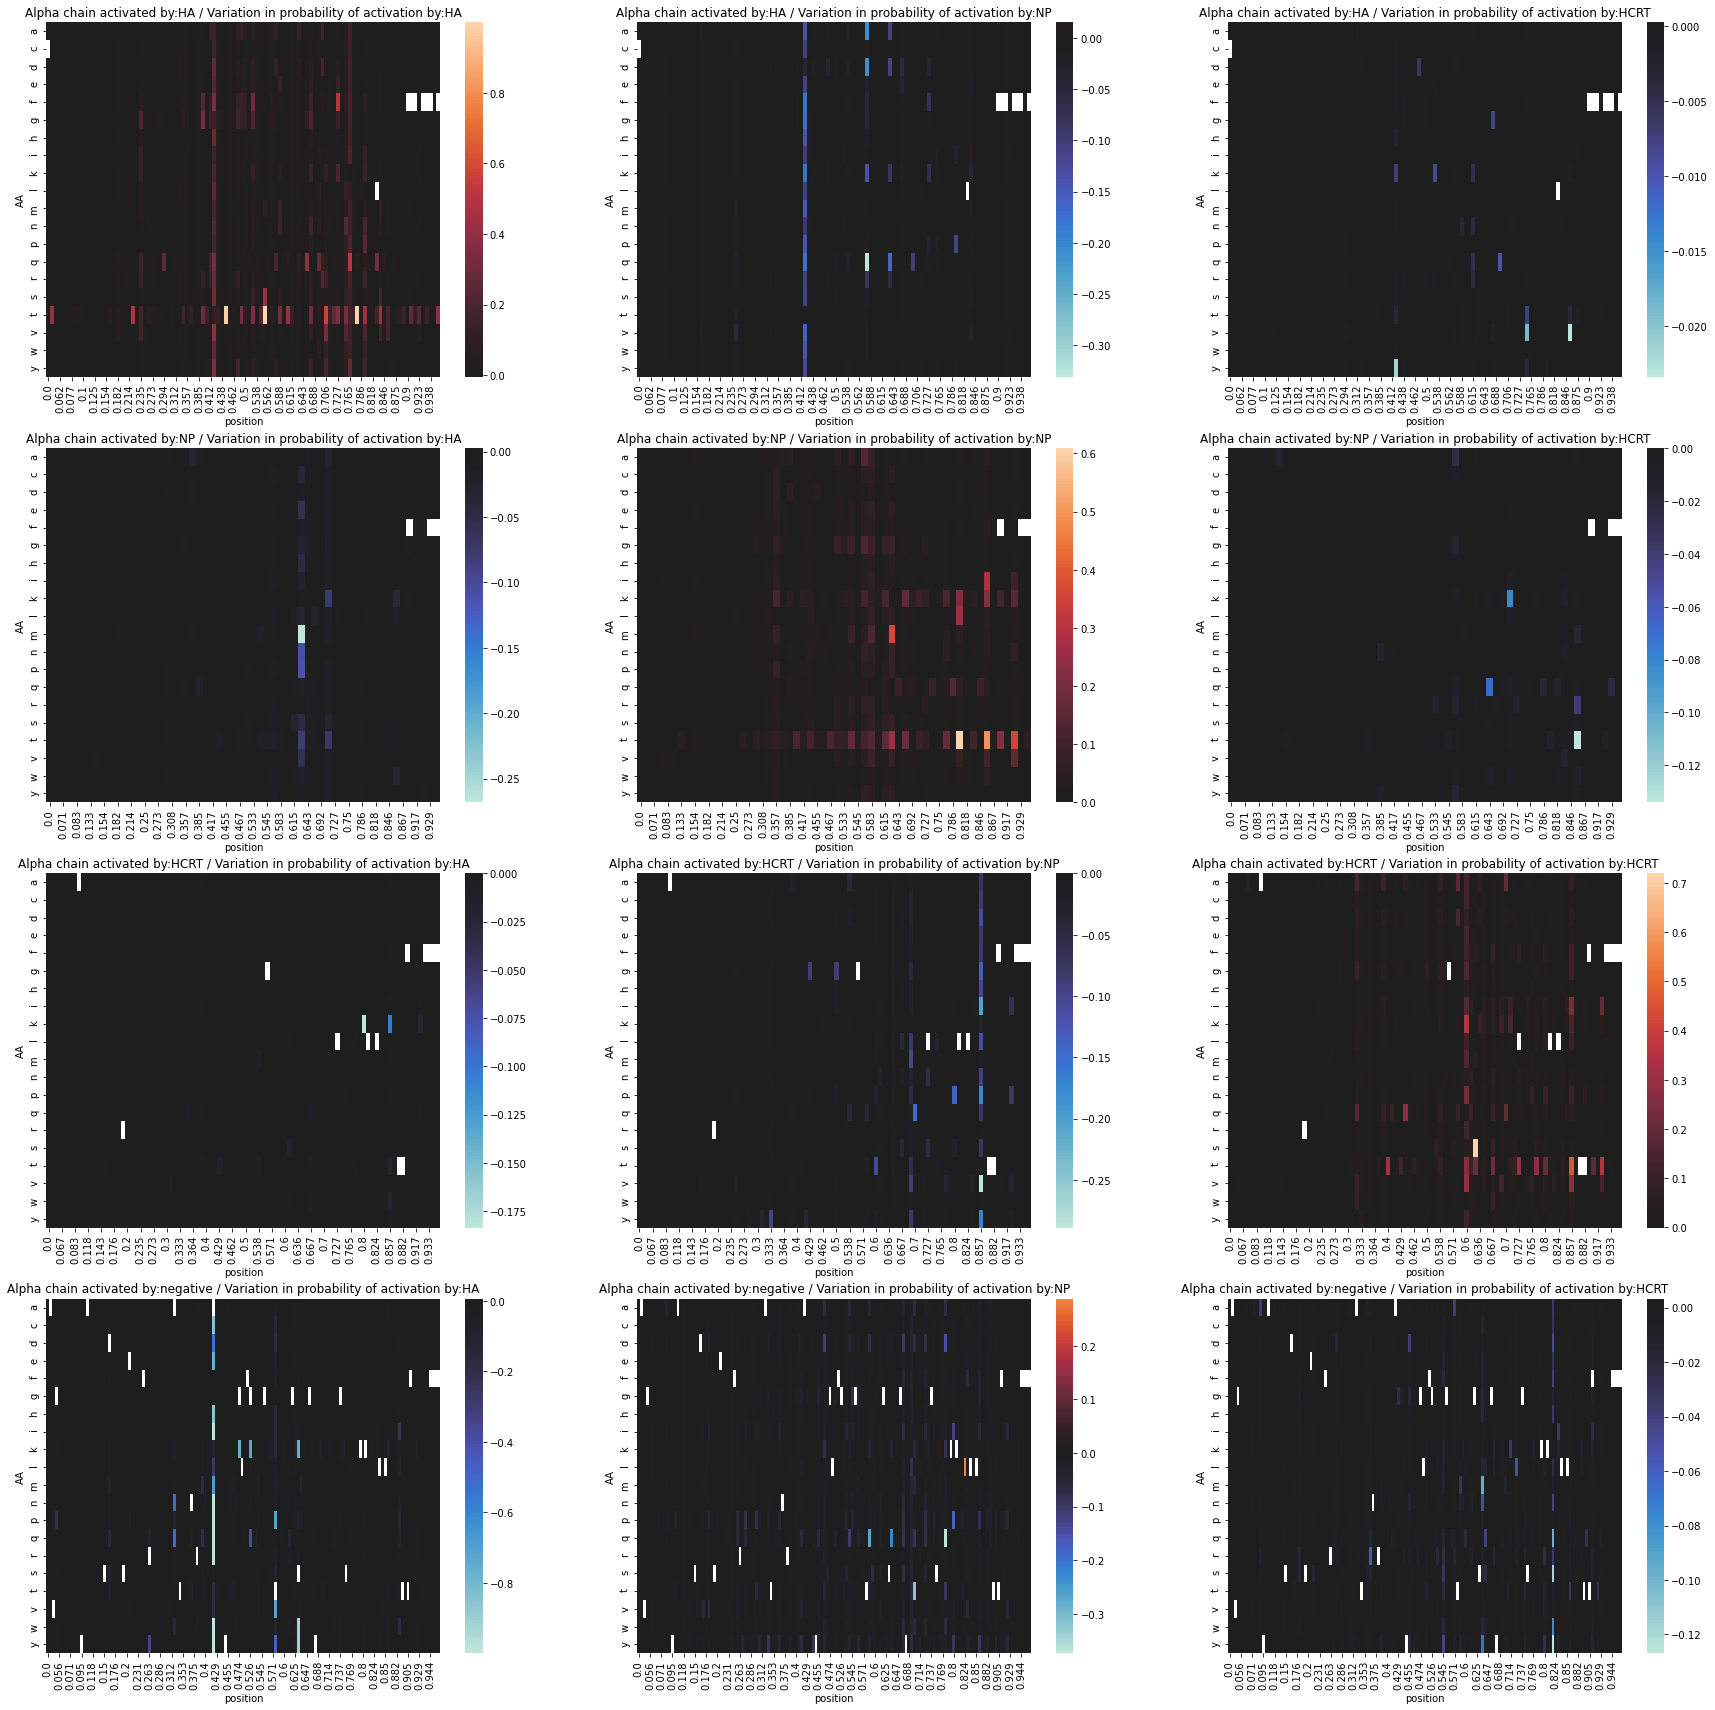

In [19]:
with open("Outputs/AA_post_delta_probs/AA_post_delta_probs_dicts/alpha_delta_probs_train.pkl", 'rb') as inFile:
    alpha = pickle.load(inFile)
    
# Compute mean alpha            
HA_alpha_mean, NP_alpha_mean, HCRT_alpha_mean, neg_alpha_mean = defaultdict(pd.DataFrame), defaultdict(pd.DataFrame), defaultdict(pd.DataFrame), defaultdict(pd.DataFrame)
mean_alpha = {'HA':HA_alpha_mean, 'NP':NP_alpha_mean, 'HCRT':HCRT_alpha_mean, 'negative':neg_alpha_mean} 

for peptide in alpha.keys():
    for prob in alpha[peptide].keys():
        for AA in AA_vocab:
            AA_mean = alpha[peptide][prob][alpha[peptide][prob]["AA"] == AA].groupby("position").mean().reset_index()
            AA_mean["AA"] = [AA] * AA_mean.shape[0]
            mean_alpha[peptide]["mean_" + prob] = pd.concat([mean_alpha[peptide]["mean_" + prob], AA_mean] , axis=0)   

%matplotlib inline
fig = plt.figure(1, figsize=(30,30))
idx = 1
for peptide in mean_alpha.keys():
    alpha_pep = mean_alpha[peptide]
    for _, pep in enumerate(["HA","NP","HCRT"]):
        plot_df = alpha_pep["mean_P_" + pep]
        plot_df.position = plot_df['position'].round(decimals=3)
        plot_df = plot_df.pivot("AA", "position", "delta_prob")
        plt.subplot(4,3,idx, facecolor='w')
        sns.heatmap(plot_df, center=0)
        plt.title("Alpha chain activated by:" + peptide + " / Variation in probability of activation by:" + pep)
        idx += 1
fig.savefig('alpha_delta_prob_train.png', facecolor='w', transparent=False)

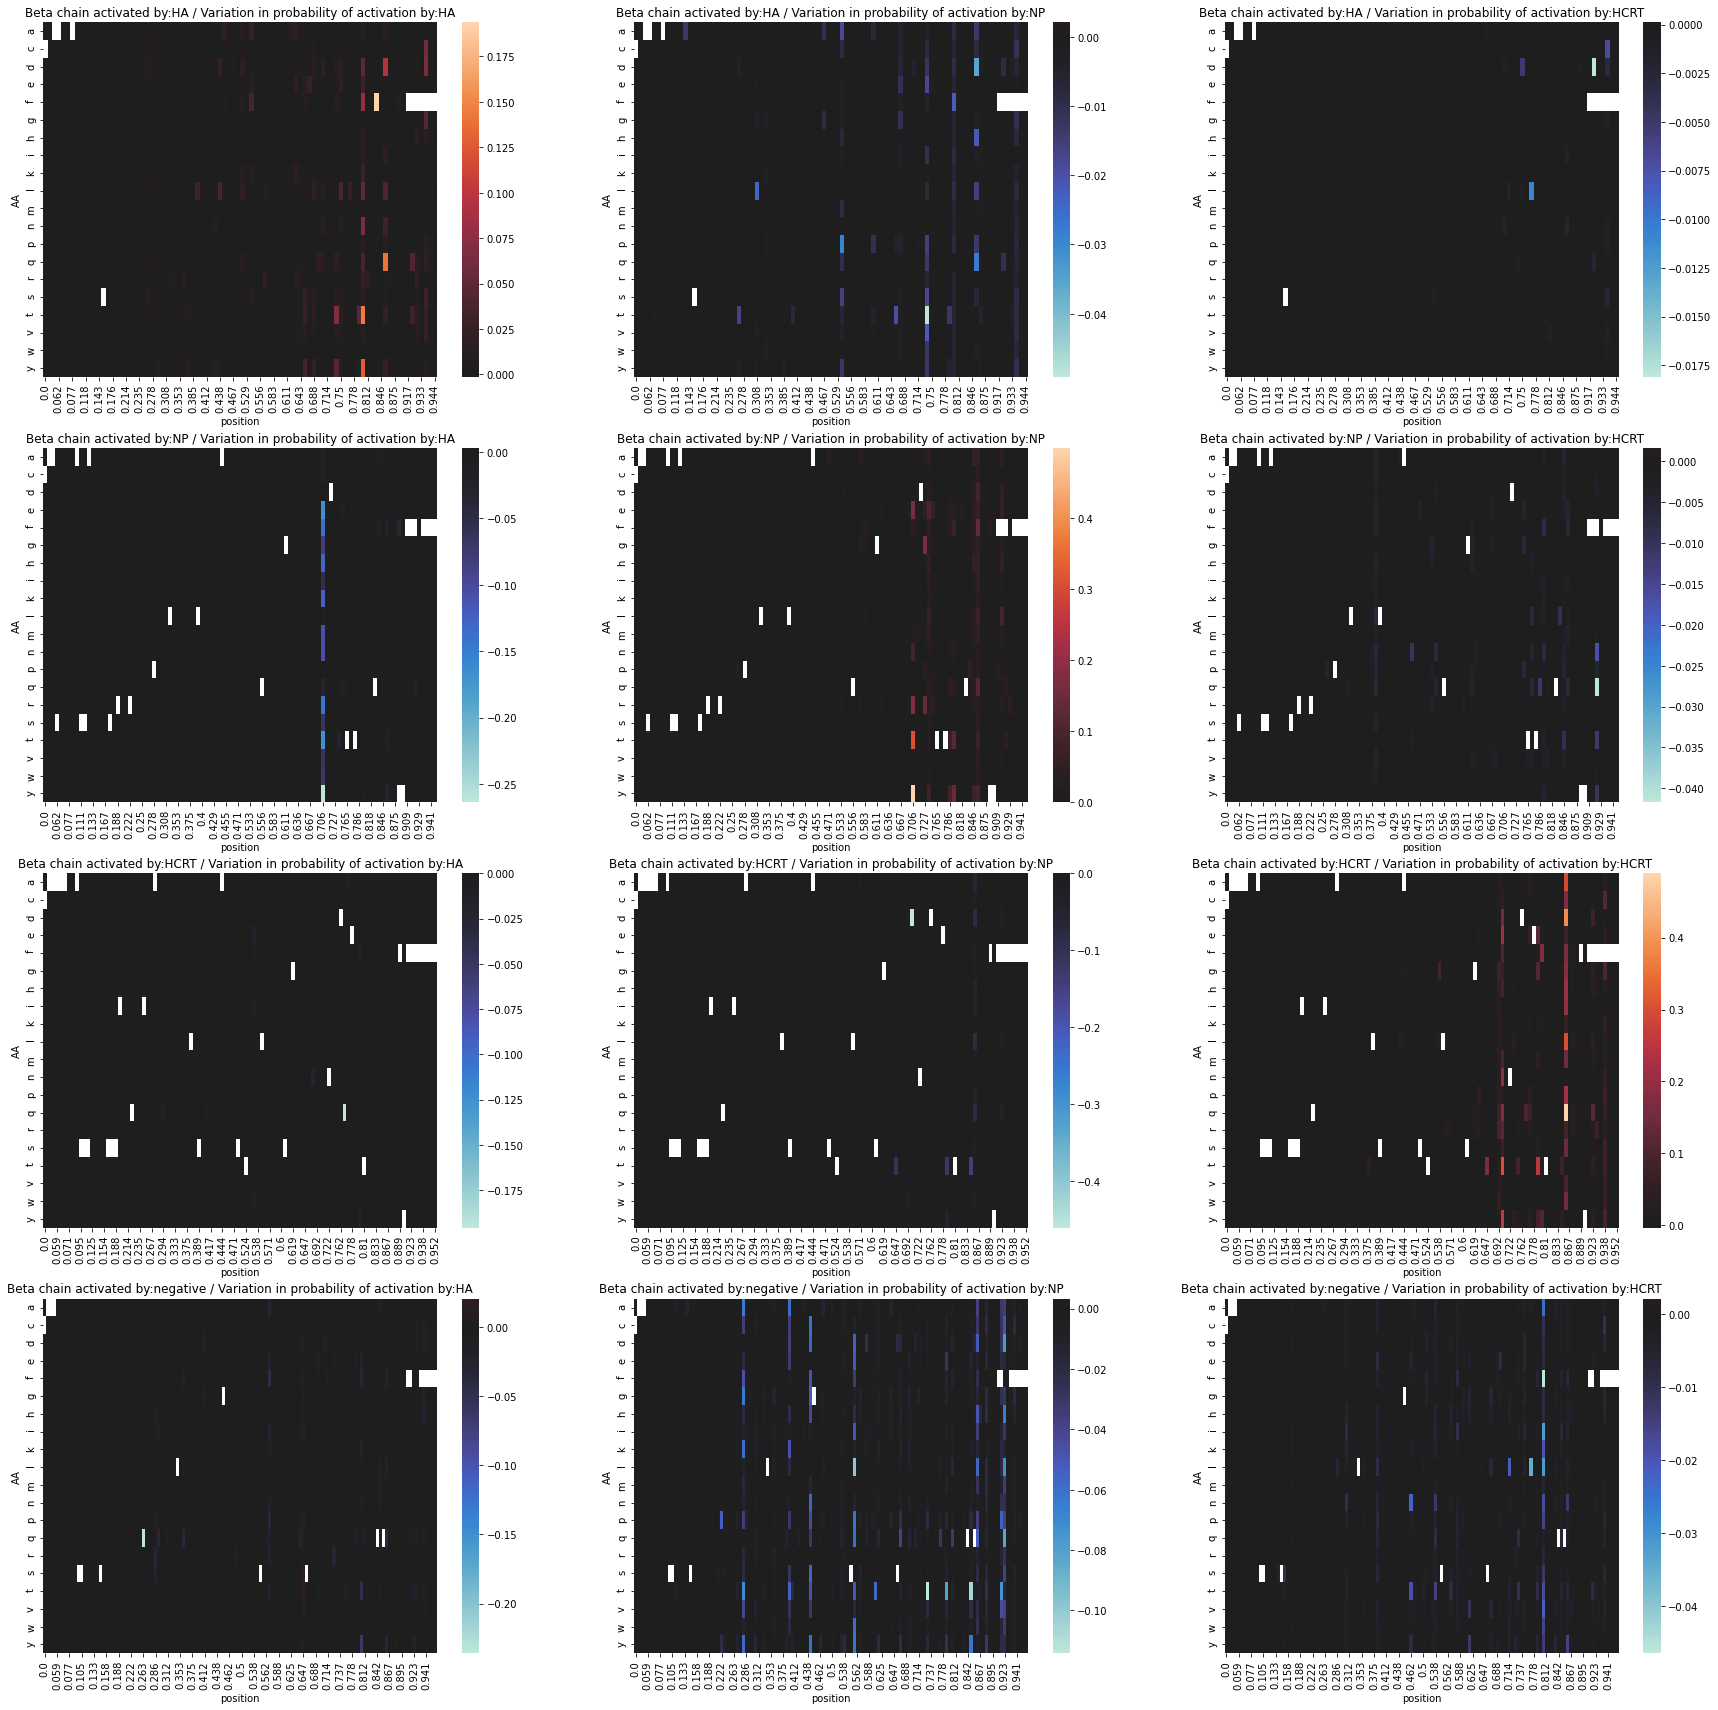

In [21]:
with open("/home/vicente/Documents/Deep Learning/DL_2021/deep-TCELL/Outputs/AA_post_delta_probs/AA_post_delta_probs_dicts/beta_delta_probs_train.pkl", 'rb') as inFile:
    beta = pickle.load(inFile)
    
    # Compute mean beta
HA_beta_mean, NP_beta_mean, HCRT_beta_mean, neg_beta_mean = defaultdict(pd.DataFrame), defaultdict(pd.DataFrame), defaultdict(pd.DataFrame), defaultdict(pd.DataFrame)
mean_beta = {'HA':HA_beta_mean, 'NP':NP_beta_mean, 'HCRT':HCRT_beta_mean, 'negative':neg_beta_mean} 

for peptide in beta.keys():
    for prob in beta[peptide].keys():
        for AA in AA_vocab:
            AA_mean = beta[peptide][prob][beta[peptide][prob]["AA"] == AA].groupby("position").mean().reset_index()
            AA_mean["AA"] = [AA] * AA_mean.shape[0]
            mean_beta[peptide]["mean_" + prob] = pd.concat([mean_beta[peptide]["mean_" + prob], AA_mean] , axis=0)

%matplotlib inline
fig = plt.figure(1, figsize=(30,30))
idx = 1
for peptide in mean_beta.keys():
    beta_pep = mean_beta[peptide]
    for _, pep in enumerate(["HA","NP","HCRT"]):
        plot_df = beta_pep["mean_P_" + pep]
        plot_df.position = plot_df['position'].round(decimals=3)
        plot_df = plot_df.pivot("AA", "position", "delta_prob")
        plt.subplot(4,3,idx)
        sns.heatmap(plot_df, center = 0)
        plt.title("Beta chain activated by:" + peptide + " / Variation in probability of activation by:" + pep)
        idx += 1
fig.savefig('beta_delta_prob_train.png', facecolor='w', transparent=False)